# Deep Learning for Text Analytics  --- Sentiment Analysis on Cryptocurrency  

### Name:                  Zhiyan Yang
### ID:          616070
### Python Version:  3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47)
###                               [MSC v.1916 64 bit (AMD64)]


## Table of Contents

    1. Introduction
    2. Data Loading 
    3. Preliminary Data Analysis: Exploratory Data Analysis (EDA)
        3.1 Basic Information
        3.2 Feature Analysis
        3.3 Target Encoding
        3.4 Class Imbalance
    4. Data Cleaning
    5. Model Selection
        5.1 Dictionary-based sentiment analysis
        5.2 RNN-based model with own embedding
        5.3 Fine-tuned DistilBERT model
        5.4 DistilBERT model with fine-tuning 
    6. Conclusion
    

## 1. Introduction
We are provided with 2000 tweets about Bitcoin and a corresponding sentiment score (which is 1 if positive
and 0 if negative). The task of this assignment is to perform sentiment analysis using a sentiment dictionary, an RNN
model, a pre-trained Transformer and a fine-tuned Transformer. 
In the following, we analyze the train and test data,preprocess the data for model training. Afterwards, different modeling approaches are considered and an NLP pipeline is chosen. Finally, the model is applied to our test data.





First, we need to import all the packages we might use in this notebook

In [1]:
import pandas as pd
import re
import pickle
from bs4 import BeautifulSoup
import emoji
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import time
import pysentiment2 as ps
import string
from collections import Counter
from datasets import Dataset


import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.nn import softmax

import transformers
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import AutoModelForSequenceClassification


---
## 2. Data Loading 

In [2]:
train = pd.read_parquet("btc_tweets_train.parquet.gzip")
test = pd.read_parquet("btc_tweets_test.parquet.gzip")

---
## 3. Preliminary Data Analysis: Exploratory Data Analysis (EDA)


### 3.1 Basic Information


### Retain data on different tweets from the same user.

After a brief look at the data, we identified that the "username" column contains duplicates. This may lead to model overfitting, as certain users might post multiple tweets with similar content. 

Of course, each user's tweets may also express different sentiments. For instance, a user who initially does not support Bitcoin may later change their mind and become a supporter. 

We can choose to retain or remove data of duplicate usernames based on different criteria. In this case, due to the limited size of our dataset, we have decided to retain these information.

Our dataset has five columns: hashtags, content, username, user_displayname, sentiment.
The column sentiment is the target and is of boolean type.

In [3]:
train.describe()

,hashtags,content,username,user_displayname,sentiment
count,1500,1500,1500,1500,1500
unique,945,1500,1012,1012,2
top,[Bitcoin],"$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,True
freq,384,1,41,41,1220


In [4]:
test.describe()

,hashtags,content,username,user_displayname,sentiment
count,500,500,500,500,500
unique,292,500,404,403,2
top,[Bitcoin],#crypto $crypto #btc \nI am Chinese crypto alp...,Peer__2__Peer,P2P⚡,True
freq,139,1,13,13,404


In [5]:
train.head()

,hashtags,content,username,user_displayname,sentiment
tweet ID,,,,,
1641579121972236290,"[Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...","$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,True
1641579176171016194,"[Bitcoin, bitcoinordinals, crypto]",Alright I have my rares. Who else is grabbing ...,spartantc81,SpartanTC,True
1641579486071390208,"[BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...","Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,SHIB Bezos,True
1641579537103302656,[BTC],📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,Algorithm.btc,True
1641579588399804418,[Bitcoin],"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,she is lucky,True


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1641579121972236290 to 1641861677149822976
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   hashtags          1500 non-null   object
 1   content           1500 non-null   object
 2   username          1500 non-null   object
 3   user_displayname  1500 non-null   object
 4   sentiment         1500 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 60.1+ KB


---
###        3.2 Feature Analysis


### Retain the columns needed for sentiment analysis

When performing sentiment analysis, it’s important to identify which columns of our data are necessary and which can be excluded.

1. remove the "username" column and the "user_displayname" column since they don't contribute to sentiment analysis. Although some users may post predominantly positive or negative content, the username itself isn't informative for classifying sentiment.


2. remove the "hashtags" column since it contains mainly hashtags related to Bitcoin and cryptocurrencies. These hashtags,while indicative of the topic of the tweets, may be of limited direct help for sentiment analysis. 


In [7]:
train.drop(columns = ['hashtags','username','user_displayname'], inplace = True)
test.drop(columns = ['hashtags','username','user_displayname'],inplace = True)
train.head()

,content,sentiment
tweet ID,,
1641579121972236290,"$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",True
1641579176171016194,Alright I have my rares. Who else is grabbing ...,True
1641579486071390208,"Bitcoin (BTC) Targets Over $100,000 as This Im...",True
1641579537103302656,📢 Xverse Web-based pool is live:\n\n•Update @x...,True
1641579588399804418,"Yesterday, a Bitcoin projection was displayed ...",True


In [8]:
test.head()

,content,sentiment
tweet ID,,
1641861708246552576,#crypto $crypto #btc \nI am Chinese crypto alp...,True
1641861783898972167,#Bitcoin would have to fall another 80% to rea...,False
1641862152532418562,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,True
1641862338369183753,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,True
1641862430434131968,Mid Day Mix-up is LIVE! Never know who might s...,True


### Remove duplicate content

Although we have chosen not to remove data of duplicate usernames, we still need to check for duplicated content. If duplicate content is found, it should be removed to prevent overfitting.

Additionally, we need to check for duplicate Twitter IDs, as the data was randomly scraped from the web and may contain duplicates due to multiple scraping sessions. Removing duplicate IDs is also crucial for preventing overfitting

Fortunately, neither of the above situations is present in our data.

In [9]:
num_duplicates1 = train['content'].duplicated().sum()
num_duplicates2 = test['content'].duplicated().sum()

print(f"Number of duplicate content in train data: {num_duplicates1}")
print(f"Number of duplicate content in test data: {num_duplicates2}")

Number of duplicate content in train data: 0
Number of duplicate content in test data: 0


In [10]:
duplicate_index1 = train.index.duplicated()
num_duplicate_indices1 = duplicate_index1.sum()
duplicate_index2 = test.index.duplicated()
num_duplicate_indices2 = duplicate_index2.sum()


print(f"Number of duplicate tweet IDs (index) in train data: {num_duplicate_indices1}")
print(f"Number of duplicate tweet IDs (index) in test data: {num_duplicate_indices2}")

Number of duplicate tweet IDs (index) in train data: 0
Number of duplicate tweet IDs (index) in test data: 0


### The data with missing values should be removed as well.

In [11]:
missing_values1 = train.isnull().sum() 
missing_values1

content      0
sentiment    0
dtype: int64

In [12]:
missing_values2 = test.isnull().sum() 
missing_values2

content      0
sentiment    0
dtype: int64

###  remove spam and bots

There are many ways to identify spam and bots. For example, we can delete tweets with ①***duplicate content***, which we have already done above. We can also identify tweets ②***containing too many links as spam or bots—typically, tweets with more than two URLs can be flagged***. Additionally, tweets that are either ③***too short or too long*** can be classified as spam or bots. 

Besides these simple rules, Machine Learning and Deep Learning approaches can also be used to detect spam and bots. For example, Machine Learning techniques like ***Random Forest and XGBoost***; Deep Learning models based on ***RNN or BERT***, can be applied as well.

Since our task involves training models based on RNN and BERT, and traditional Machine Learning models like Random Forest require labeled data indicating which tweets are spam or bots, and our dataset lacks such labels, we use simpler methods to identify and remove spam and bots in this case.

### Filter out tweets that are too short (less than 5 words) or too long (more than 100 words)

In [13]:
train['word_count'] = train['content'].apply(lambda x: len(x.split()))
train = train[(train['word_count'] >= 5) & (train['word_count'] <= 100)]

test['word_count'] = test['content'].apply(lambda x: len(x.split()))
test = test[(test['word_count'] >= 5) & (test['word_count'] <= 100)]


In [14]:
train.drop(columns = ['word_count'], inplace = True)
test.drop(columns = ['word_count'], inplace = True)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 1641579121972236290 to 1641861677149822976
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    1483 non-null   object
 1   sentiment  1483 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 24.6+ KB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 1641861708246552576 to 1641953216999968769
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    497 non-null    object
 1   sentiment  497 non-null    bool  
dtypes: bool(1), object(1)
memory usage: 8.3+ KB


### Filter out tweets with too many URLs (using a threshold of more than 2 URLs in a tweet)

In [17]:
def count_urls(text):
    url_pattern = re.compile(r'(https?://\S+)')
    return len(url_pattern.findall(text))

In [18]:
train['url_count'] = train['content'].apply(count_urls)
train = train[train['url_count'] <= 2]

test['url_count'] = test['content'].apply(count_urls)
test = test[test['url_count'] <= 2]

In [19]:
train.drop(columns = ['url_count'], inplace = True)
test.drop(columns = ['url_count'], inplace = True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 1641579121972236290 to 1641861677149822976
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    1463 non-null   object
 1   sentiment  1463 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 24.3+ KB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 1641861708246552576 to 1641953216999968769
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    492 non-null    object
 1   sentiment  492 non-null    bool  
dtypes: bool(1), object(1)
memory usage: 8.2+ KB


###         3.3 Target Encoding


Binary-encode the target variable

In [21]:
train['sentiment'] = train['sentiment'].map({True:1,False:0})
train['sentiment'].value_counts()

1    1184
0     279
Name: sentiment, dtype: int64

In [22]:
test['sentiment'] = test['sentiment'].map({True:1,False:0})
test['sentiment'].value_counts()

1    396
0     96
Name: sentiment, dtype: int64

### 3.4 Class Imbalance

We found that the number of tweets with a sentiment value of 1 is much higher than the number of tweets with a sentiment value of 0,leading to a ***Class Imbalance*** problem

There are varies ways to address Class Imbalance: Oversampling, Undersampling, Class Weighting, SMOTE to create synthetic Data,etc.
Since our first model：using a sentiment dictionary for sentiment analysis, and the third model：Applying the DistilBERT model which was fine-tuned for sentiment analysis, are both pre-trained models, this notebook will mainly focus on handling Class Imbalance in the RNN-based modeling.

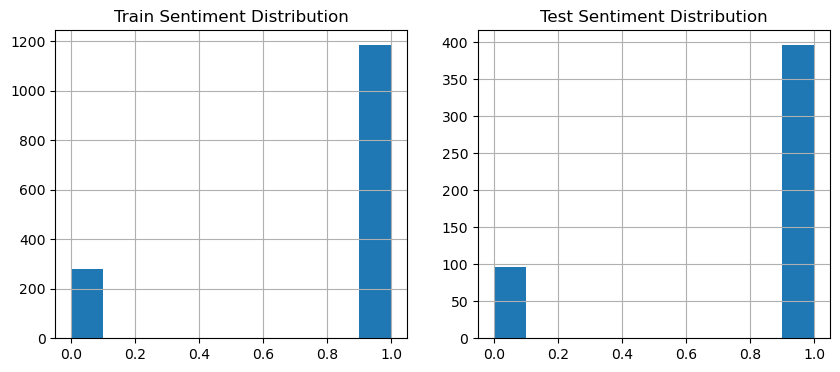

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
train['sentiment'].hist(ax=axs[0])
axs[0].set_title('Train Sentiment Distribution')
test['sentiment'].hist(ax=axs[1])
axs[1].set_title('Test Sentiment Distribution')
plt.show()


---
### We first randomly select a row of data and print it out so that we can use it for comparison during subsequent data processing/cleaning. 

In [24]:
print(train.iloc[105, 0])
print(train.iloc[105,1])

Wall St gains with tech shares; regional banks fall - Reuters

$SNAP $HOOD $CORZ $BKKT $AMC $NIO 

#BTC  #SHIB 
#HOGE #SAITAMA #BNB #DOGE #ETH #BabyFloki #AltCoinSeason 
 https://t.co/MjGEJsQCZs
1


In [25]:
print(test.iloc[13, 0])
print(test.iloc[13,1])

🕰️ Patience is key when it comes to #Bitcoin adoption. 

It’s unfair to believe that #Bitcoin adoption can happen immediately. Look how long it took for the #euro to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ @paoloardoino #FinancialFreedom.⏳ https://t.co/ug0W59MMCg
0


In [26]:
train.head(10)

,content,sentiment
tweet ID,,
1641579121972236290,"$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",1
1641579176171016194,Alright I have my rares. Who else is grabbing ...,1
1641579486071390208,"Bitcoin (BTC) Targets Over $100,000 as This Im...",1
1641579537103302656,📢 Xverse Web-based pool is live:\n\n•Update @x...,1
1641579588399804418,"Yesterday, a Bitcoin projection was displayed ...",1
1641579652681543680,Unpopular opinion:\n\nThis pump isn’t going to...,0
1641580545678393345,Solid bid in major ALT/BTC pairs today. \n\nIf...,1
1641580600606769152,"If you're filing 2022 taxes in the U.S., you s...",1
1641581112852971524,"IBIS SACRED, new solana project. metaverse com...",1


---
## 4. Data Cleaning


### We're now ready to perform text cleaning. 
The following steps are performed:

   1. remove hashtags and mention 
   2. remove whitespace
   3. remove html
   4. remove hyperlinks
   5. ***Conversion of Emojis and Emoticons***
   6. ***remove punctuation and lowercasing***            
   7. ***Stopwords are filtered out***                  
   8. ***The words are lemmatized***                   


### Notice!
For Dictionary-based sentiment analysis and RNN-based model, our preprocessing of the data must be as perfect as possible, so all data-cleaning steps are required.

BERT models have strong contextual understanding and usually do not require excessive preprocessing of the data. So the preprocessing of data in steps5，6,7, and 8 can be ignored when using BERT models.

1. remove hashtags

Based on our observation of the data, we found that the hashtags in the "content" column, such as #Bitcoin and #crypto,etc., are merely topic identifiers and do not directly express the sentiment. Therefore, removing them may help to reduce the noise and thus improve the accuracy of the sentiment analysis.


In [27]:
train['cleaned_content'] = train['content'].apply(lambda x: re.sub(r'#\w+', '', x))
test['cleaned_content'] = test['content'].apply(lambda x: re.sub(r'#\w+', '', x))

In [28]:
train['cleaned_content'] = train['cleaned_content'].apply(lambda x: re.sub(r'@\w+', '', x))
test['cleaned_content'] = test['cleaned_content'].apply(lambda x: re.sub(r'@\w+', '', x))

In [29]:
def remove_stock_symbols(text):
    return re.sub(r'\$\w+', '', text)

train['cleaned_content'] = train['cleaned_content'].apply(remove_stock_symbols)
test['cleaned_content'] = test['cleaned_content'].apply(remove_stock_symbols)


In [30]:
print(train.iloc[105,2])

Wall St gains with tech shares; regional banks fall - Reuters

      

   
       
 https://t.co/MjGEJsQCZs


In [31]:
print(test.iloc[13,2])

🕰️ Patience is key when it comes to  adoption. 

It’s unfair to believe that  adoption can happen immediately. Look how long it took for the  to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’  .⏳ https://t.co/ug0W59MMCg


2. Define the function to remove whitespace


In [32]:
def remove_whitespace(text):
    """
    Function to remove whitespace(tabs, newlines).
    """
    return ' '.join(text.split())

In [33]:
train['cleaned_content'] = train['cleaned_content'].apply(remove_whitespace)
test['cleaned_content'] = test['cleaned_content'].apply(remove_whitespace)

In [34]:
print(train.iloc[105,2])

Wall St gains with tech shares; regional banks fall - Reuters https://t.co/MjGEJsQCZs


In [35]:
print(test.iloc[13,2])

🕰️ Patience is key when it comes to adoption. It’s unfair to believe that adoption can happen immediately. Look how long it took for the to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ .⏳ https://t.co/ug0W59MMCg


3. remove html content

In [36]:
def remove_html(text):
    soup = BeautifulSoup(text)
    
    return soup.get_text()

In [37]:
train['cleaned_content'] = train['cleaned_content'].apply(remove_html)
test['cleaned_content'] = test['cleaned_content'].apply(remove_html)


C:\Users\User\AppData\Local\Temp\ipykernel_8784\1355316594.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


In [38]:
print(train.iloc[105,2])


Wall St gains with tech shares; regional banks fall - Reuters https://t.co/MjGEJsQCZs


In [39]:
print(test.iloc[13,2])

🕰️ Patience is key when it comes to adoption. It’s unfair to believe that adoption can happen immediately. Look how long it took for the to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ .⏳ https://t.co/ug0W59MMCg


4. remove hyperlinks

In [40]:
def remove_hyperlinks(text):
    return re.sub(r'(https?://\S+)','',text)

In [41]:
train['cleaned_content'] =  train['cleaned_content'].apply(remove_hyperlinks)
test['cleaned_content'] =  test['cleaned_content'].apply(remove_hyperlinks)

In [42]:
train.iloc[105,2]

'Wall St gains with tech shares; regional banks fall - Reuters '

In [43]:
test.iloc[13,2]

'🕰️ Patience is key when it comes to adoption. It’s unfair to believe that adoption can happen immediately. Look how long it took for the to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ .⏳ '

We save the processed data into pickle files, so that we can skip the above data processing steps during model-training in the future

In [44]:
with open('train_cleaned_content.pkl','wb') as file:
    pickle.dump(train['cleaned_content'],file)
    

with open('test_cleaned_content.pkl','wb') as file:
    pickle.dump(test['cleaned_content'],file)
    

    
with open('train_cleaned_content.pkl','rb') as file:
    train['cleaned_content'] = pickle.load(file)

    
with open('test_cleaned_content.pkl','rb') as file:
    test['cleaned_content'] = pickle.load(file)

5. Conversion of Emojis and Emoticons

In [45]:
def convert_emojis(text):
    return emoji.demojize(text)


train['cleaned_content'] = train['cleaned_content'].apply(convert_emojis)
test['cleaned_content'] = test['cleaned_content'].apply(convert_emojis)

In [46]:
train.iloc[105,2]

'Wall St gains with tech shares; regional banks fall - Reuters '

In [47]:
test.iloc[13,2]

':mantelpiece_clock: Patience is key when it comes to adoption. It’s unfair to believe that adoption can happen immediately. Look how long it took for the to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ .:hourglass_not_done: '

 6. remove punctuation and lowercasing

In [48]:
def remove_punctuation_and_casing(text):
    """
    Function to remove the punctuation, upper casing and words that include
    non-alphanumeric characters.
    """
    chars = '’‘\'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    text = text.translate(str.maketrans(chars, ' ' * len(chars)))
   
    return ' '.join([word.lower() for word in text.split()])
    
train['cleaned_content'] =  train['cleaned_content'].apply(remove_punctuation_and_casing)   
test['cleaned_content'] =  test['cleaned_content'].apply(remove_punctuation_and_casing)    

In [49]:
train.iloc[105,2]

'wall st gains with tech shares regional banks fall reuters'

In [50]:
test.iloc[13,2]

'mantelpiece clock patience is key when it comes to adoption it s unfair to believe that adoption can happen immediately look how long it took for the to be adopted in europe it was forced on people bitcoin is a much better story hourglass not done'

7. Stopwords are filtered out

In [51]:
english_stopwords = stopwords.words('english')
english_stopwords[0:9]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you']

In [52]:
def remove_stopwords(text):
    """ Function to remove stopwords. """
    return ' '.join([word for word in str(text).split() if word not in english_stopwords])

train['cleaned_content'] = train['cleaned_content'].apply(remove_stopwords)
test['cleaned_content'] = test['cleaned_content'].apply(remove_stopwords)


In [53]:
train.iloc[105,2]

'wall st gains tech shares regional banks fall reuters'

In [54]:
test.iloc[13,2]

'mantelpiece clock patience key comes adoption unfair believe adoption happen immediately look long took adopted europe forced people bitcoin much better story hourglass done'

8. The words are lemmatized

In [55]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text, **kwargs):
    """ Function to lemmatize words. """
    return ' '.join([lemmatizer.lemmatize(word, **kwargs) for word in text.split()])


train['cleaned_content'] = train['cleaned_content'].apply(lemmatize_words)
test['cleaned_content'] = test['cleaned_content'].apply(lemmatize_words)

In [56]:
train.iloc[105,2]

'wall st gain tech share regional bank fall reuters'

In [57]:
test.iloc[13,2]

'mantelpiece clock patience key come adoption unfair believe adoption happen immediately look long took adopted europe forced people bitcoin much better story hourglass done'

### Most Used Words

In [58]:
import collections
word_counter = collections.Counter()
for r in train['cleaned_content']:
    for w in r.split():        
        word_counter.update({w: 1})  

In [59]:
top_n = 10
word_counter.most_common(top_n)

[('face', 159),
 ('u', 144),
 ('index', 137),
 ('fire', 133),
 ('1', 133),
 ('pointing', 131),
 ('backhand', 130),
 ('light', 124),
 ('like', 115),
 ('market', 113)]

---
# 5. Model Selection
### 5.1 Dictionary-based sentiment analysis

In [60]:
x_train = train['cleaned_content']
y_train = train['sentiment']

x_test = test['cleaned_content']
y_test = test['sentiment']

In [61]:
(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

((1463,), (492,), (1463,), (492,))

Dictionary-based sentiment analysis

import Harvard IV-4 dictionary


In [62]:
dc = ps.HIV4()

def get_sentiment_score(text):
    score = round(dc.get_score(dc.tokenize(text))['Polarity'],2)
    normalized_score = (score + 1) / 2 
    return normalized_score

Compare the sentiment score with the raw sentiment value using the previous example

In [63]:
sentiment_score = get_sentiment_score(train['cleaned_content'].iloc[105])

print(f"Content: {train['cleaned_content'].iloc[105]}")
print(f"Raw Sentiment : {train['sentiment'].iloc[105]}")
print(f"Sentiment Score: {sentiment_score}")

Content: wall st gain tech share regional bank fall reuters
Raw Sentiment : 1
Sentiment Score: 0.5


Apply the model in our test dataset

In [64]:
start = time.time()
train['sentiment_score'] = train['cleaned_content'].apply(get_sentiment_score)
test['sentiment_score'] = test['cleaned_content'].apply(get_sentiment_score)
end = time.time()

print('Processed {} contents in {:.0f} sec.'.format(train.shape[0], end-start))
print('Processed {} contents in {:.0f} sec.'.format(test.shape[0], end-start))

Processed 1463 contents in 1 sec.
Processed 492 contents in 1 sec.


count    492.000000
mean       0.598984
std        0.322362
min        0.000000
25%        0.445000
50%        0.600000
75%        1.000000
max        1.000000
Name: sentiment_score, dtype: float64

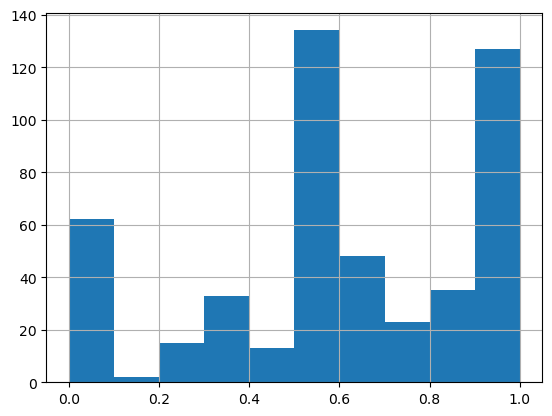

In [65]:
test['sentiment_score'].hist()
test['sentiment_score'].describe() 

### Sentiment classifier assessment

In [67]:
def assess_sentiment_classifier(ytest, yhat, cut_off=0.5, plot_roc=True):   
    """
        Helper function to assess a classification model in terms of the AUC
        and classification accuracy. We calculate the latter by comapring
        continuous (e.g., probabilistic) classifier predictions to a cut_off.
        Cases where the prediction exceeds the cut-off are classified as 
        positive.
    """
    
    # Calculate discrete class predictions
    yhat_c = np.where(yhat>cut_off, 1, 0)
    
    
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_c)
    auc = roc_auc_score(ytest, yhat)
    
    
    # Calculate recall and F1 score
    recall = recall_score(ytest, yhat_c)
    f1 = f1_score(ytest, yhat_c)

    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_c)
    
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    return auc, acc, recall,f1,cmat

Assess dictionary-based sentiment classifier


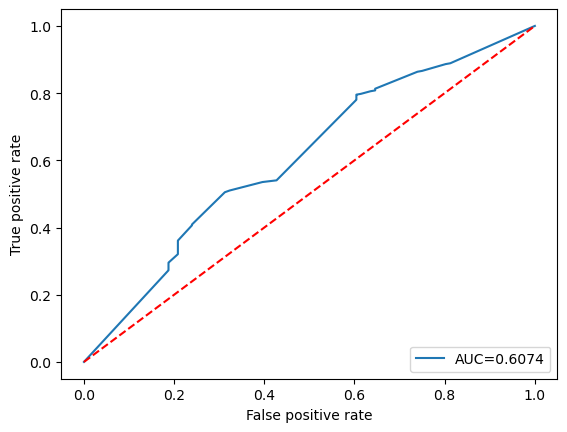

Dictionary-based sentiment classifier:	AUC=0.6074	Accuracy=0.5467	Recall=0.5404	F1 Score=0.6575


In [68]:
from sklearn.metrics import recall_score, f1_score
auc, acc,recall,f1,cmat = assess_sentiment_classifier(ytest=test['sentiment'], yhat=test['sentiment_score'], cut_off=0.5)
print("Dictionary-based sentiment classifier:\tAUC={:.4f}\tAccuracy={:.4f}\tRecall={:.4f}\tF1 Score={:.4f}".format(auc, acc,recall,f1))

 Confusion matrix 


In [69]:
cmat

array([[ 55,  41],
       [182, 214]], dtype=int64)

The ROC curve doesn’t look good, and the accuracy value is also very low. It seems that our Dictionary-based model is not a good model.

Dictionary-based approach does not involve training. Therefore, there is no risk of overfitting.

Since we are about to create more models, it makes sense to create a container in which we store the results of different models.

In [70]:
# Extract test set cases 
yhat = test.loc[x_test.index, 'sentiment_score']                

# Compute test set performance
auc, acc, recall,f1,_ = assess_sentiment_classifier(y_test, yhat, cut_off=0.5, plot_roc=False)

# We will create many more models. Let's put every model's score into a data frame
test_scores = pd.DataFrame(index=['Acc', 'AUC','Recall','F1_score'], columns=['Dictonary_based'], data=[acc, auc,recall,f1])
test_scores

,Dictonary_based
Acc,0.546748
AUC,0.607442
Recall,0.540404
F1_score,0.657450


---
### 5.2 RNN-based Model

Before training the model,we first split our dataset into a test and a validation set.

In [71]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_content'], train['sentiment'], test_size = 0.25, random_state = 616070)

# transform them to numpy
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

x_test = test['cleaned_content']
y_test = test['sentiment']
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

# Define the size of the vocabulary and the max number of words in a sequence
vocab_size = 10000
seq_length = 50

# Create a vectorization layer
vectorize_layer = TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )
vectorize_layer.adapt(X_train)

In [72]:
X_train = vectorize_layer(X_train)
X_val = vectorize_layer(X_val)
x_test = vectorize_layer(x_test)

### Create model with LSTM


In [73]:
emb_size = 128
rnn_units = 64
input = tf.keras.Input(shape=(seq_length,), dtype="int64")
emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input)
x = layers.LSTM(rnn_units)(emb)
output = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(input, output)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 50, 128)           │       1,280,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 50)                │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          49,408 │ embedding[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1)                 │              65 │ lstm[0][0]                 │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

### Adjust weights to address Class Imbalance in the model

In [74]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [75]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = 10,
    batch_size = 128,
    class_weight = dict(enumerate(class_weights))
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5608 - loss: 0.6975 - val_accuracy: 0.7322 - val_loss: 0.6864
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7374 - loss: 0.6956 - val_accuracy: 0.7322 - val_loss: 0.6814
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7661 - loss: 0.6851 - val_accuracy: 0.6011 - val_loss: 0.6766
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7300 - loss: 0.6583 - val_accuracy: 0.6066 - val_loss: 0.6452
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7292 - loss: 0.5780 - val_accuracy: 0.7514 - val_loss: 0.5285
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8618 - loss: 0.4099 - val_accuracy: 0.7678 - val_loss: 0.5127
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8995 - loss: 0.3183 - val_accuracy: 0.7923 - val_loss: 0.5466
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9464 - loss: 0.2170 - val_accuracy: 0.8005 - val_loss: 0.5903


In [85]:
print(train['cleaned_content'].iloc[105])
model.predict(vectorize_layer(train['cleaned_content'].iloc[[105]]))


wall st gain tech share regional bank fall reuters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


array([[0.95560455]], dtype=float32)

### Bi-directional LSTM

In [77]:
input = tf.keras.Input(shape=(seq_length,), dtype="int64")
emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input)
x = layers.Bidirectional(layers.LSTM(rnn_units))(emb)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(input, output)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 50, 128)           │       1,280,000 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 50)                │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 128)               │          98,816 │ embedding_1[0][0],         │
│                               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ bidirectional[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             129 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = 10,
    batch_size = 128,
    class_weight=dict(numerate = (class_weights))
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.7042 - loss: 0.6647 - val_accuracy: 0.8060 - val_loss: 0.5547
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8124 - loss: 0.5312 - val_accuracy: 0.8060 - val_loss: 0.5188
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8262 - loss: 0.4795 - val_accuracy: 0.8060 - val_loss: 0.5011
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8040 - loss: 0.4707 - val_accuracy: 0.8060 - val_loss: 0.4950
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8130 - loss: 0.4096 - val_accuracy: 0.8060 - val_loss: 0.5305
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8946 - loss: 0.2751 - val_accuracy: 0.8197 - val_loss: 0.6159
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9561 - loss: 0.1660 - val_accuracy: 0.8169 - val_loss: 0.6501
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9742 - loss: 0.1178 - val_accuracy: 0.8142 - val_loss:

In [79]:
model.predict(vectorize_layer(train['cleaned_content'].iloc[[105]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


array([[0.95588964]], dtype=float32)

In [80]:
model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([[0.79530036],
       [0.03045814],
       [0.99984145],
       [0.63500595],
       [0.80878866],
       [0.99536675],
       [0.985414  ],
       [0.5053849 ],
       [0.999949  ],
       [0.30048743],
       [0.9998555 ],
       [0.99986076],
       [0.41130054],
       [0.99991643],
       [0.999967  ],
       [0.7055516 ],
       [0.9998771 ],
       [0.99983764],
       [0.4750825 ],
       [0.9999687 ],
       [0.872756  ],
       [0.9920952 ],
       [0.94740564],
       [0.9703625 ],
       [0.999923  ],
       [0.6437392 ],
       [0.99930596],
       [0.9076742 ],
       [0.01495086],
       [0.9572413 ],
       [0.9999605 ],
       [0.97824055],
       [0.8020448 ],
       [0.9999643 ],
       [0.9998545 ],
       [0.35881907],
       [0.66650367],
       [0.9999606 ],
       [0.99993175],
       [0.95535785],
       [0.9909096 ],
       [0.9901331 ],
       [0.9995119 ],
       [0.9921235 ],
       [0.99985594],
       [0.99992186],
       [0.9330197 ],
       [0.999

In [81]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")  
y_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
count = y_pred_df['Prediction'].value_counts()
count

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


1    454
0     38
Name: Prediction, dtype: int64

### Using the GRU layer instead of the LSTM, create the text classification model and compare if there is a significant gain

In [83]:
input = tf.keras.Input(shape=(seq_length,), dtype="int64")
emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input)
x = layers.Bidirectional(layers.GRU(rnn_units))(emb)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(input, output)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 50, 128)           │       1,280,000 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_3 (NotEqual)        │ (None, 50)                │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_2               │ (None, 128)               │          74,496 │ embedding_3[0][0],         │
│ (Bidirectional)               │                           │                 │ not_equal_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ bidirectional_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │             129 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,354,625 (5.17 MB)

 Trainable params: 1,354,625 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = 10,
    batch_size = 128,
    class_weight = dict(enumerate(class_weights))
                   )

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6185 - loss: 0.6853 - val_accuracy: 0.6421 - val_loss: 0.6873
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6657 - loss: 0.6843 - val_accuracy: 0.6913 - val_loss: 0.6783
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8020 - loss: 0.6683 - val_accuracy: 0.6612 - val_loss: 0.6709
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8136 - loss: 0.6434 - val_accuracy: 0.6831 - val_loss: 0.6467
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8383 - loss: 0.6051 - val_accuracy: 0.7186 - val_loss: 0.6020
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8759 - loss: 0.5081 - val_accuracy: 0.7678 - val_loss: 0.5004
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8924 - loss: 0.3570 - val_accuracy: 0.7541 - val_loss: 0.4857
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9310 - loss: 0.2038 - val_accuracy: 0.7869 - val_loss: 

In [86]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")  
y_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
count = y_pred_df['Prediction'].value_counts()
count

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


1    398
0     94
Name: Prediction, dtype: int64

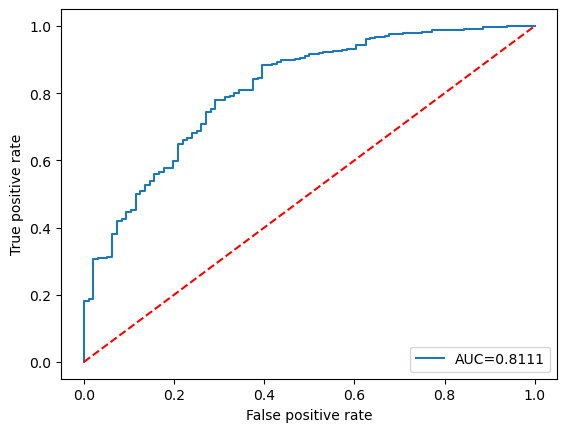

,Dictonary_based,Bidirectional-RNN(GRU)
Acc,0.546748,0.833333
AUC,0.607442,0.811132
Recall,0.540404,0.898990
F1_score,0.657450,0.896725


In [87]:
auc, acc, recall, f1, _ = assess_sentiment_classifier(y_test, y_pred_prob, cut_off=0.5)
test_scores['Bidirectional-RNN(GRU)'] = [acc, auc, recall, f1]
test_scores

---
### 5.3 Fine-tuned DistilBERT model

open the pkl file 

In [88]:
with open('test_cleaned_content.pkl','rb') as file:
    test['cleaned_content'] = pickle.load(file)

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 1641579121972236290 to 1641861677149822976
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   content          1463 non-null   object 
 1   sentiment        1463 non-null   int64  
 2   cleaned_content  1463 non-null   object 
 3   sentiment_score  1463 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 57.1+ KB


Take a look at the same example again

In [90]:
test.iloc[13,2]

'🕰️ Patience is key when it comes to adoption. It’s unfair to believe that adoption can happen immediately. Look how long it took for the to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ .⏳ '

In [91]:
x_train = train['cleaned_content']
y_train = train['sentiment']
x_test = test['cleaned_content']
y_test = test['sentiment']


In [92]:
classifier = pipeline('sentiment-analysis',
                      model='distilbert-base-uncased-finetuned-sst-2-english',
                      tokenizer='distilbert-base-uncased',
                      batch_size=128)

E:\anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [93]:
def pipeline_classify(data):
    ''' Function to run the sentiment analysis pipeline on each row of a dataset
    and extract the scores. '''

    predictions = []

    for row in data:
          classification = classifier(row,truncation = True)[0]
         
          if classification['label'] == 'POSITIVE':
              predictions.append(classification['score'])
          else:
              predictions.append(1-classification['score'])
              
    return predictions

In [94]:
predictions = pipeline_classify(x_test)

In [95]:
print(classifier(test['cleaned_content'].iloc[13]))
print(test['cleaned_content'].iloc[13])

[{'label': 'NEGATIVE', 'score': 0.996677041053772}]
🕰️ Patience is key when it comes to adoption. It’s unfair to believe that adoption can happen immediately. Look how long it took for the to be adopted in Europe; it was forced on people. ‘Bitcoin is a much better story’ .⏳ 


In [96]:
predictions

[0.00713503360748291,
 0.01638972759246826,
 0.4195851683616638,
 0.1432529091835022,
 0.9864757657051086,
 0.006978929042816162,
 0.01033329963684082,
 0.020403385162353516,
 0.006278336048126221,
 0.7122544646263123,
 0.005004167556762695,
 0.9950345754623413,
 0.0029802918434143066,
 0.0033229589462280273,
 0.05920577049255371,
 0.001165926456451416,
 0.48027706146240234,
 0.9971518516540527,
 0.02181297540664673,
 0.9976398944854736,
 0.9988106489181519,
 0.021445930004119873,
 0.006086289882659912,
 0.017328262329101562,
 0.14693236351013184,
 0.034387826919555664,
 0.0026648640632629395,
 0.9991746544837952,
 0.0038000941276550293,
 0.16049069166183472,
 0.9919666051864624,
 0.001102447509765625,
 0.06301474571228027,
 0.004880666732788086,
 0.9488604664802551,
 0.010795533657073975,
 0.046220481395721436,
 0.6858282685279846,
 0.9996397495269775,
 0.970508337020874,
 0.2861059904098511,
 0.9995386600494385,
 0.0016779303550720215,
 0.03639894723892212,
 0.9983785152435303,
 0.00

In [97]:
def assess_sentiment_classifier(ytest, yhat, cutoff=0.5, plot_roc=True):
    ''' Function to assess a classification model in terms of the AUC
    and classification accuracy. '''

    # Calculate discrete class predictions
    yhat_discrete = np.where(pd.DataFrame(yhat)>cutoff, 1, 0)
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_discrete)
    auc = roc_auc_score(ytest, yhat)
    
    recall = recall_score(ytest, yhat_discrete)
    f1 = f1_score(ytest, yhat_discrete)
    
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_discrete)
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}\tRecall={:.4f}\tF1_score={:.4f}".format(auc, acc,recall,f1))
    print('Confusion matrix:')
    print(cmat)
    
    return (auc,acc,recall,f1)

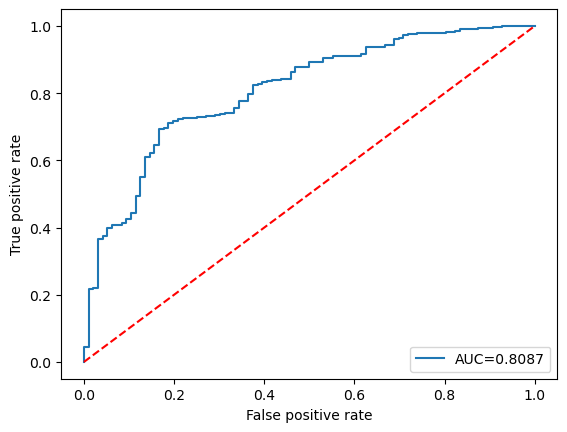

NN test set performance:	AUC=0.8087	Accuracy=0.5813	Recall=0.5101	F1_score=0.6623
Confusion matrix:
[[ 84  12]
 [194 202]]


(0.8087121212121212, 0.5813008130081301, 0.51010101010101, 0.662295081967213)

In [98]:
assess_sentiment_classifier(y_test, predictions)

In [99]:
test_scores['DistilBERT'] = assess_sentiment_classifier(y_test, predictions, cutoff=0.5, plot_roc=False)


NN test set performance:	AUC=0.8087	Accuracy=0.5813	Recall=0.5101	F1_score=0.6623
Confusion matrix:
[[ 84  12]
 [194 202]]


In [100]:
test_scores

,Dictonary_based,Bidirectional-RNN(GRU),DistilBERT
Acc,0.546748,0.833333,0.808712
AUC,0.607442,0.811132,0.581301
Recall,0.540404,0.898990,0.510101
F1_score,0.657450,0.896725,0.662295


---
### 5.4 Finetuning a pretrained huggingface model

distilbert-base-uncased-finetuned-sst-2-english is a model that has already been fine-tuned on the SST-2 dataset and is specifically designed for sentiment analysis. Therefore, it is better suited for sentiment classification tasks.(As we already did before)

distilbert-base-uncased is a general-purpose, non-fine-tuned DistilBERT model that has not been optimized for specific tasks such as sentiment classification. We will perform fine-tuning on this model.



---
Load and preprocess the dataset

Note: 'train' and 'test' are pre-loaded DataFrames containing 'cleaned_content' and 'sentiment' columns

In [101]:
with open('train_cleaned_content.pkl','rb') as file:
    train['cleaned_content'] = pickle.load(file)
    
with open('test_cleaned_content.pkl','rb') as file:
    test['cleaned_content'] = pickle.load(file)

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 1641579121972236290 to 1641861677149822976
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   content          1463 non-null   object 
 1   sentiment        1463 non-null   int64  
 2   cleaned_content  1463 non-null   object 
 3   sentiment_score  1463 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 57.1+ KB


In [103]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 1641861708246552576 to 1641953216999968769
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   content          492 non-null    object 
 1   sentiment        492 non-null    int64  
 2   cleaned_content  492 non-null    object 
 3   sentiment_score  492 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 35.4+ KB


Extract text and labels from train and test sets

In [104]:
x_train = train['cleaned_content']
y_train = train['sentiment']
x_test = test['cleaned_content']
y_test = test['sentiment']


In [105]:
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

Initialize the tokenizer for DistilBERT

In [106]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


E:\anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenization function: Applies tokenization and padding/truncation to the dataset

In [107]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=50)

Create datasets for training and testing using the Hugging Face datasets library

In [108]:
train_dataset = Dataset.from_dict({"text": x_train, "label": y_train})
test_dataset = Dataset.from_dict({"text": x_test, "label": y_test})

Apply the tokenization function to the datasets

In [109]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1463 [00:00<?, ? examples/s]

Map:   0%|          | 0/492 [00:00<?, ? examples/s]

Convert datasets to PyTorch tensors format

In [110]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Load the pre-trained DistilBERT model with a classification head

In [111]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the training arguments for the Trainer API

In [112]:
training_args = TrainingArguments(
    output_dir='./results',                  # Output directory for model checkpoints
    evaluation_strategy="epoch",             # Evaluate the model at the end of each epoch
    learning_rate=5e-5,                       # Learning rate for the optimizer
    per_device_train_batch_size=16,          # Batch size for training
    per_device_eval_batch_size=64,           # Batch size for evaluation
    num_train_epochs=1,                      # Number of training epochs
    weight_decay=0.01,                       # Weight decay for regularization
    logging_dir='./logs',                     # Directory for storing logs
    logging_steps=10,                        # Log every 10 steps
)

E:\anaconda\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Initialize the Trainer for model fine-tuning

In [113]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Train the model on the training dataset


In [114]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.399200,0.377500


TrainOutput(global_step=92, training_loss=0.4483770216288774, metrics={'train_runtime': 379.104, 'train_samples_per_second': 3.859, 'train_steps_per_second': 0.243, 'total_flos': 18925762132200.0, 'train_loss': 0.4483770216288774, 'epoch': 1.0})

After training, evaluate the model on the test dataset

Extract the predicted probabilities for the positive class

In [115]:
predictions = trainer.predict(test_dataset)

y_pred_proba = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()  

The same assess_sentiment_classifier function returns AUC, accuracy, recall, and F1 score

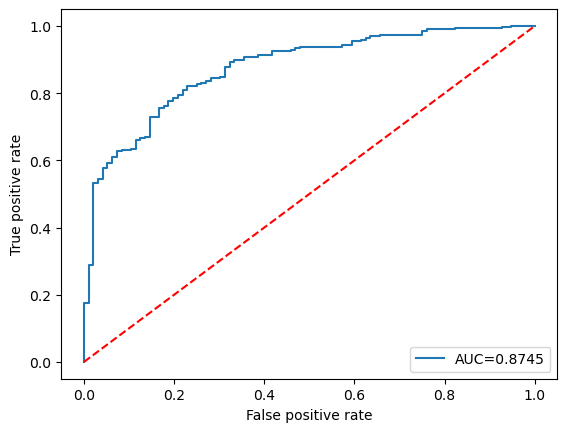

NN test set performance:	AUC=0.8745	Accuracy=0.8049	Recall=1.0000	F1_score=0.8919
Confusion matrix:
[[  0  96]
 [  0 396]]


In [116]:
auc, acc, recall, f1 = assess_sentiment_classifier(y_test, y_pred_proba, cutoff=0.5, plot_roc=True)


Add the evaluation results to an existing DataFrame for comparison with other models

In [117]:
test_scores['DistilBERT_finetuned'] = [acc, auc, recall, f1]
test_scores

,Dictonary_based,Bidirectional-RNN(GRU),DistilBERT,DistilBERT_finetuned
Acc,0.546748,0.833333,0.808712,0.804878
AUC,0.607442,0.811132,0.581301,0.874527
Recall,0.540404,0.898990,0.510101,1.000000
F1_score,0.657450,0.896725,0.662295,0.891892


---
## 6. Conclusion

### Up to this point, we have discussed various methods for building sentiment analysis models. Let's take a look at the test-scores table again.

In [118]:
test_scores

,Dictonary_based,Bidirectional-RNN(GRU),DistilBERT,DistilBERT_finetuned
Acc,0.546748,0.833333,0.808712,0.804878
AUC,0.607442,0.811132,0.581301,0.874527
Recall,0.540404,0.898990,0.510101,1.000000
F1_score,0.657450,0.896725,0.662295,0.891892


The models are evaluated based on four metrics: ***Accuracy (Acc), Area Under the ROC Curve (AUC), Recall, and F1 Score.***
    
1. Accuracy (Acc)

Best Performance: The Bidirectional RNN model has the highest accuracy , indicating that it performs the best in correctly classifying samples.


Lowest Performance: The Dictionary_based model has the lowest accuracy, suggesting it struggles the most with correctly classifying samples.



2. AUC (Area Under the Curve)

Best Performance: The fine-tuned DistilBERT model achieves the highest AUC, indicating it has the best ability to distinguish between positive and negative classes across different thresholds.

Lowest Performance: The pre-trained DistilBERT has the lowest AUC, suggesting it is not well-suited for this specific task and struggles to distinguish between the two classes.



3. Recall

Best Performance: The fine-tuned DistilBERT model has the highest recall, meaning it effectively identifies most of the positive cases, though it may sacrifice some precision.

Lowest Performance: The pre-trained DistilBERT has the lowest recall, indicating that it misses a significant number of positive cases.



4. F1 Score

Best Performance: The fine-tuned DistilBERT model has the highest F1 Score , showing it performs best in balancing precision and recall.

Lowest Performance: The Dictionary_based model has the lowest F1 Score, indicating it performs poorly in balancing these two aspects


---
The fine-tuned DistilBERT model performs the best: The DistilBERT_finetuned model excels across all four metrics, particularly in AUC and F1 Score, demonstrating its high adaptability and accuracy for the sentiment analysis task.

The pre-trained DistilBERT performs poorly: While DistilBERT is a powerful model, its performance on the sentiment analysis task is significantly lower when not fine-tuned, highlighting the importance of task-specific fine-tuning.

RNN-based model performs well: The RNN-based model also shows strong performance, particularly in accuracy and recall, but it slightly lags behind the fine-tuned DistilBERT in terms of AUC and F1 Score.

Dictionary-based model performs the worst: The Dictionary_based model has the lowest scores across all metrics, indicating its limitations in handling the complexities of natural language sentiment analysis.

### Overall, this task underscores the effectiveness of fine-tuning pre-trained models like DistilBERT for specific tasks like sentiment analysis, leading to significantly better performance.

In [119]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [120]:
with open('requirements.txt', 'r') as file:
    content = file.read()
    print(content)


absl-py==2.1.0
accelerate==0.33.0
aext_assistant @ file:///C:/b/abs_05zbnpu9if/croot/aext-assistant_1698112951886/work
aext_assistant_server @ file:///C:/b/abs_83f6_dptu3/croot/aext-assistant-server_1698104652697/work/backend_lib/assistant
aext_core @ file:///C:/b/abs_abml9re1ky/croot/aext-core_1698107590809/work
aext_core_server @ file:///C:/b/abs_dev7ac1xol/croot/aext-core-server_1698098831843/work/backend_lib/core
aext_shared @ file:///C:/b/abs_306_rwdm13/croot/aext-shared_1698068353440/work/backend_lib/shared
aiobotocore @ file:///C:/b/abs_3cwz1w13nn/croot/aiobotocore_1701291550158/work
aiofiles @ file:///C:/b/abs_9ex6mi6b56/croot/aiofiles_1683773603390/work
aiohttp @ file:///C:/b/abs_27h_1rpxgd/croot/aiohttp_1707342354614/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///C:/b/abs_9djc_0pyi3/croot/aiosqlite_1683773915844/work
alabaster @ file:///home/ktietz/src/ci/al